<a id="introduction"></a>
# Introduction 

This Python notebook is the continuation of [this](https://mishathings.org/2024-08-06-losing-myself-in-the-greenhouse-effect.html) blog post. For the notebook itself (rather than this html version), click [here](https://mishathings.org/greenhouse-blog-final.ipynb).

Disclaimer: I am no atmospheric scientist, so I cannot make any strong claims about the accuracy or realism of the model. I have few pretentions: I'm playing. For fun and to explore. 

If you only care about the fun, and not about the work, you can skip to the part called [Playing](#playing).


# The model

## Importing libraries

In [145]:
import matplotlib.pyplot as plt
import numpy as np 

## Creating a layer class

This section defines a class called "Layer", which has a method called "update_layer". The model uses this class to create instances (objects) of this class, and adds them to a list, after which it calls the method "update_layer" on each of the objects, every time step.



In [146]:
class Layer:
    def __init__(self, pos):
        # pos is the position of this Layer object in a list of Layer objects
        self.pos = pos
        # Energy flux upwards
        self.outgoing_up = 0
        #Energy flux downwards
        self.outgoing_down = 0
        # To store values throughout a time loop
        self.incoming_store = []
        self.temp_store = []

        # This little if-statement makes it possible to both run the model with one
        # absorbtion rate, and run it with a list of layer-specific (altitude dependent) 
        # absorbtion rate.
        if len(absorbtion) == 1:
            self.absorbtion = absorbtion[0]
        else:
            self.absorbtion = absorbtion[self.pos]

    # This method calculates how much energy a layer receives from the layers above 
    # and below. The temp_plot argument determines what kind of temperature is shown
    # in the plot. More explanation below.
    def update_layer(self,temp_plot="self"):
        # Each round of updates the incoming energy of a layer is set to 0, 
        # after which it will be "built up" from the outgoing energy from 
        # layers above and below
        self.incoming = 0

        # If the layer is the first layer (the surface), it receives a constant 
        # inflow of energy
        if self.pos == 0:
            # The earth has a radiating temperature of 255 °K, which fits with
            # a flux of about 239 W/m2. Let's assume for now that all of this 
            # outgoing energy was once absorbed and re-radiated by the surface.
            self.incoming = 239

        # RADIATION FROM LAYERS BELOW
        # Select layers 0 up to but not including itself.
        for layer in layers[0:self.pos]:
            # Get the overall transparency rate of the layers in between self.pos (the layer
            # for which we are calculating the incoming energy) and layer.pos (the layer from
            # which we are determining the input).
            
            # The transparency rate is 1 for directly adjacent layers, meaning that all 
            # energy emitted by directly adjacent layers reaches the layer under consideration.
            if self.pos-layer.pos == 1:
                pass_between = 1
            else:
                pass_between = 1
                # Looping from one layer above layer.pos up to but not including self.pos
                # Multiplying the transparency rates (1-absorbtion)
                for x in layers[layer.pos+1:self.pos]:
                    pass_between=pass_between*(1-x.absorbtion)
            
            # Take each outgoing_up, multiply this with the overall transparency rate
            # Note that this incoming energy still has to be multiplied with the absorbtion 
            # rate. See below.
            self.incoming = self.incoming + layer.outgoing_up*pass_between
           

        # RADIATION FROM LAYERS ABOVE
        # This part does not apply to the top layer, because it does not receive anything from above.
        if self.pos < (number_layers-1):
            # Loop over the layers above self.pos
            for layer in layers[self.pos+1:]:
                # The transparency rate is 1 for directly adjacent layers, meaning that all 
                # energy emitted by directly adjacent layers reaches the layer under consideration.
                if layer.pos-self.pos == 1:
                    pass_between = 1
                # Looping from one layer above self.pos up to but not including layer.pos
                # Multiplying the transparency rates (1-absorbtion)
                else:
                    pass_between = 1
                    for x in layers[self.pos+1:layer.pos]:
                        pass_between=pass_between*(1-x.absorbtion)
                        
                # Take each outgoing_down, multiply this with the overall transparency rate
                # Note that this incoming energy still has to be multiplied with the absorbtion 
                # rate. See below.
                self.incoming = self.incoming + layer.outgoing_down*pass_between

        # If the layer is the surface, all radiation is absorbed, and all goes up
        if self.pos == 0:
            self.outgoing_up = self.incoming
        # For all other layers, only a fraction of incoming energy is absorbed, and it is
        # re-readiated upward and downward.
        else:
            self.outgoing_up = self.incoming*self.absorbtion/2
            self.outgoing_down = self.incoming*self.absorbtion/2

        # Each layer radiates a percentage to space (I keep track of this to check if the model works)
        # To do this, I calculate the overall transparency rate of all layers above the self.
        pass_between = 1
        for x in layers[self.pos+1:]:
            pass_between=pass_between*(1-x.absorbtion)
        self.to_space = self.outgoing_up*pass_between

        # Calculate temperature per layer. Reminder #3: to calculate the temperature of a layer, we should
        # only use outgoing_up or outgoing_down, since this is what the "object" radiates. If we pick
        # outgoing_up (instead of outgoing_down), it also works for the surface (layer 1) (which does 
        # not have outgoing_down).
        if temp_plot == "self":
            self.temp = ((self.outgoing_up/SBC)**(1/4))
        else:
            if self.pos == 0:
                self.temp = ((self.incoming)/SBC)**(1/4)
            else:
                self.temp = ((self.incoming/2)/SBC)**(1/4)
                

        # Store incoming energy and temperature
        self.incoming_store.append(self.incoming)
        self.temp_store.append(self.temp)


## Some constants

In [147]:
# Stefan Boltzmann constant
SBC = 5.670374419*(10**-8)
time = range(50)

## Run and plot function

In [148]:
def run_and_plot(temp_plot="self"):

    # the variable "layers" (a list of Layer objects) apparently 
    # has to be a global variable. I think because I'm using it 
    # in the method of the class Layer?
    global layers
    layers = []

    # Creating the layers
    for x in range(number_layers):
        layers.append(Layer(x))

    # RUNNING MODEL
    for t in time:
        space_layers = []
        # Every time step every layer is sequentially updated. Starting from the bottom.
        for ind, layer in enumerate(layers):
            layer.update_layer(temp_plot = temp_plot)
            # Building a list of "energy lost to space per layer"
            space_layers.append(layer.to_space)
            
    # Calculate for each layer, the fraction of radiation emitted sent to space
    frac_space = [i / j for i, j in zip(space_layers,[x.incoming for x in layers])]
    
    # Taking the list "space_layers" of last model run, and sum up energy lost of those layers
    sum_space_tot=sum(space_layers)
    # Create a list that shows what fraction of total energy lost is lost per layer
    sum_space_part=[x / sum_space_tot for x in space_layers]
    print(f'Total energy sent back to space (sum_space_tot) {round(sum_space_tot,2)} W.m-2.s-2')

    # PLOTTING
    plot_layers_temp = [x.temp_store for x in layers]

    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(5, 15))

    # First subplot for the line plots
    for ind, temp_in_kelvin in enumerate(plot_layers_temp):
        max_val = np.max(temp_in_kelvin)
        if ind == 0:
            axs[0].plot(time, temp_in_kelvin, label=f"Surface (Max: {max_val-273.15:.2f}°C)")
        else:
            axs[0].plot(time, temp_in_kelvin, label=f"Layer {ind} (Max: {max_val-273.15:.2f}°C)")

    
    y1, y2 = axs[0].get_ylim()
    x1, x2 = axs[0].get_xlim()
    
    ax2 = axs[0].twinx()
    ax2.set_ylim(y1-273.15, y2-273.15)
    ax2.set_yticks( range(int(y1-273.15), int(y2-273.15), 3*number_layers))
    ax2.set_ylabel('Temp in °C')
    ax2.set_xlim(x1, x2)
    
    axs[0].set_ylabel('Temp in °K')
    axs[0].set_xlabel('Time')
    axs[0].legend()
    axs[0].set_title("Temp different layers")
    
    # Second subplot for bar plot
    xticklabels = ['surf']+[str(i) for i in np.arange(1, len(sum_space_part))] 
    axs[1].bar(xticklabels, sum_space_part)
    axs[1].set_xlabel('Origin of energy loss')
    axs[1].set_ylabel('Fraction of energy flux J.s-2.m-2/J.s-2.m-2')
    axs[1].set_title("Fraction of total energy\nloss to space by origin")

    # Third subplot for bar plot
    xticklabels = ['surf']+[str(i) for i in np.arange(1, len(sum_space_part))] 
    axs[2].bar(xticklabels, frac_space, color='red')
    axs[2].set_xlabel('Origin of energy loss')
    axs[2].set_ylabel('Fraction of energy flux J.s-2.m-2/J.s-2.m-2')
    axs[2].set_title("Fraction of emitted radiation\nthat is lost to space\n(per surface/layer)")
    
    
    
    plt.tight_layout()
    plt.show()


<a id="playing"></a>
# Playing 

## Testing the one-layer atmosphere model

Let's first run the model with ...

- ... only one atmospheric layer. Because the model counts the surface as a layer, the value of `number_layers` is 2.
- ... an absorbtion rate of 1 (which means that this one layer absorbs all radiation emitted by the surface).
- ... an incoming radiation that is similar to what corresponds to the Earth's effective temperature of 255°K (= 239 J.m<sup>-2</sup>.s<sup>-2</sup>).

Plot 1 below confirms the temperatures of [Kump et al.](https://mishathings.org/public/Kump-p53.pdf) (303°K on the surface and 255°K in the atmosphere, which translates to respectively 30°C and -18°C).

Because the absorbtion rate is 1 (100%), none of the radiation emitted by the surface is lost to space. Plot 2 indeed shows that all energy lost to space, originates from the atmospheric layer instead, which therefore has to have a temperature of 255°K.

Plot 3 shows that the top layer sends half of it's energy upwards (to space) (because the other half is sent downwards).

Total energy sent back to space (sum_space_tot) 239.0 W.m-2.s-2


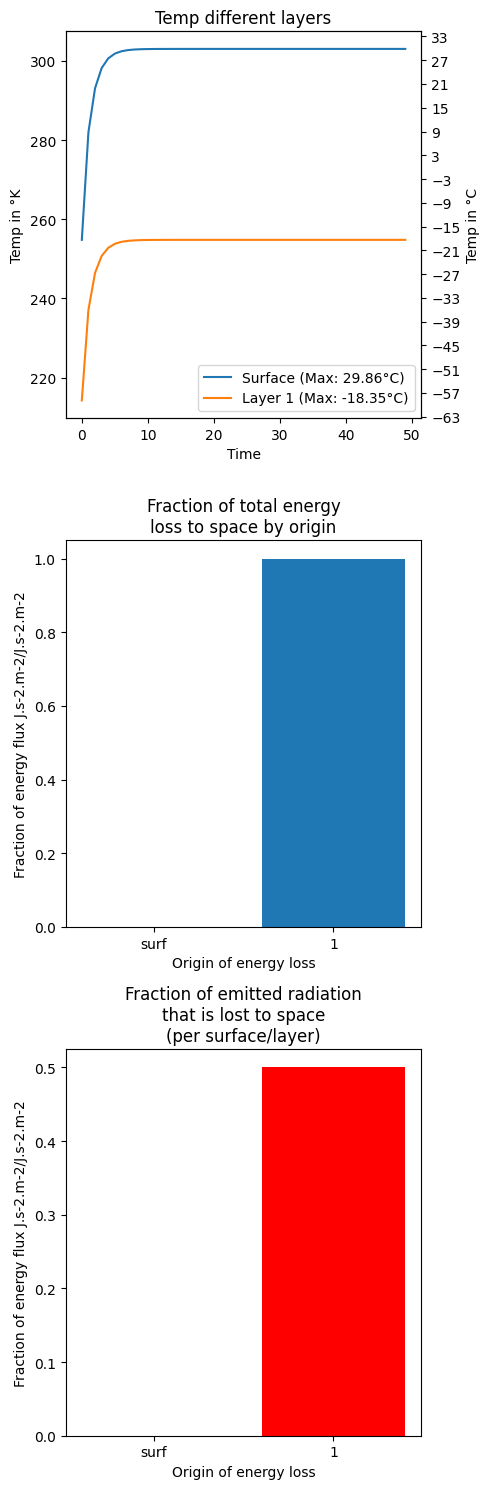

In [149]:
absorbtion = [1]
number_layers = 2 # The bottom layer is the surface
run_and_plot()

## Testing absorbtion

In the the one-layer atmosphere model of Kump et al., the atmosphere absorbs all radiation that the surface emits. 

As Kump et al. were already alluding to, and as the image below shows, radiation of different wavelengths is differently absorbed by different gases. Implementing something like this would be a bit much for a little side project like this, so I will simplify things a bit.

For now I will pick one absorbtion rate for the entire atmosphere, without distinguishing between different wavelengths. (I will sometimes talk about the transparency rate, which simply is `1 - absorbtion`).

<img src="Atmospheric_Transmission.png" alt="drawing" width="500"/>

The picture below shows that of the 390 W.m<sup>-2</sup> that the surface emits, about 40 W.m<sup>-2</sup> escapes straight to space (see also the [atmospheric window](https://en.wikipedia.org/wiki/Atmospheric_window)). 

![energy balance](balance.jpeg "Energy balance")

So for now, let's just have an absorbtion rate of `1 - (40/390)`, which is more or less 0.9. This means that about 10% of the energy that the surface emits is radiated into space (a transparency rate of 0.1).

The plots below show what happens. Plot 3 shows that the surface indeed sends 10% of it's emissions straight to space. 

Plot 2 shows that when it comes to the relative contribution of the surface to the total amount of energy lost to space (necessarily 239 W.m<sup>-2</sup>), the percentage goes up to almost 20%. 

Plot 1 shows why: the surface has a higher temperature, and thus a higher upward flux (we have to bear in mind that, following the Stefan-Boltzmann law, a temperature that twice as high, generates a flux that is 2<sup>4</sup> times larger). Because this surface flux now also contributes to the energy loss to space, both the surface and the atmospheric layer can be colder, without affecting the overall energy loss to space (239 W.m<sup>-2</sup>).

Total energy sent back to space (sum_space_tot) 239.0 W.m-2.s-2


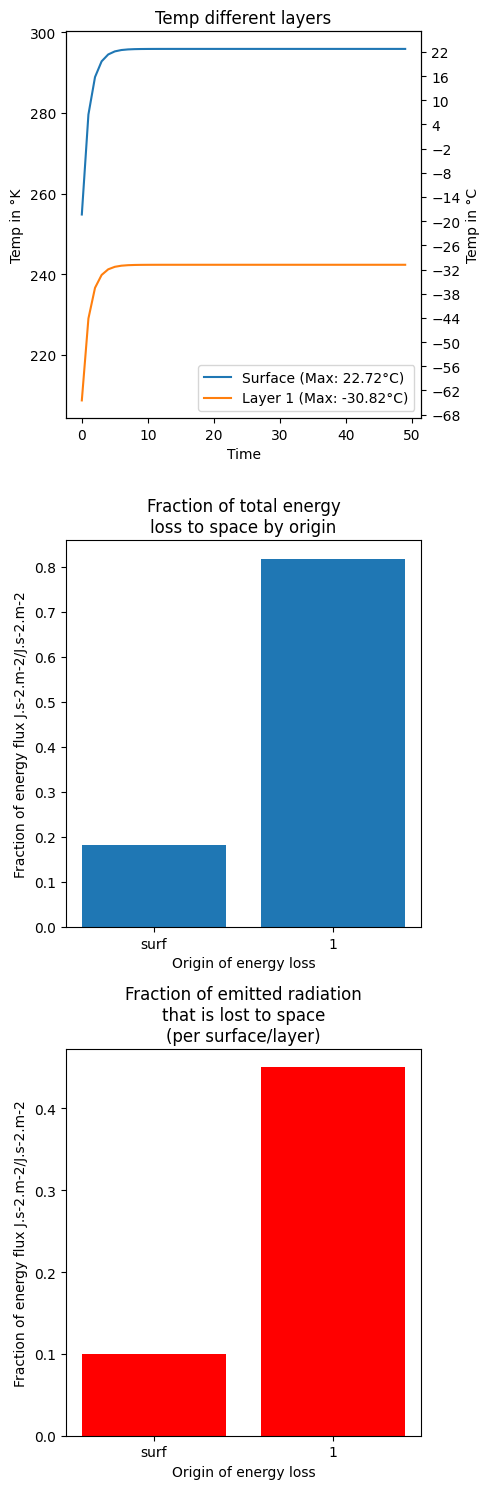

In [150]:
absorbtion = [0.90]
number_layers = 2
run_and_plot()

So to recap: in a one-layer atmosphere with an absorbtion rate of 1, only the atmosphere can lose energy to space, so that layer needs to be 255°C (the temperature necessary to emit 239 W.m<sup>-2</sup> to space).

When the surface can also emit radiation to space, both the surface and the atmosphere can have a lower temperature.

We can play with the values of the plots to see if it all adds up:

In [151]:
# Convert to °K
surface_temp_K = 22.72 + 273.15
layer1_temp_K = -30.82 + 273.15

# Calculate fluxes
flux_surf = 5.67*10**-8 * surface_temp_K**4
# total flux of layer1 is upward and downward, hence *2
flux_layer1 = 2 * 5.67*10**-8 * layer1_temp_K**4 

# Check if 10% of the surface flux + 50% of the atmosphere flux adds up to 239
print(f"{0.1*flux_surf + 0.5*flux_layer1} W/m2")

238.97897453263403 W/m2


## Testing layers

The one-layer atmosphere model presented by Kump et al. has ... one layer.

The model I am presenting here allows for more layers.

The plots below show what happens when the model is run with three layers (again, because the model treats the surface as a layer, the value of `number_layers` is 4). The absorbtion rate is 1 (which means that the layers have a transparency rate of 0).

As a result, as plot 3 and 2 show, only the top layer (layer 3) can emit radiation to space. 

This top layer needs to have a temperature of 255°C in order to lose the necessary 239 W.m<sup>-2</sup>. Plot 1 shows that this is indeed the case.


Total energy sent back to space (sum_space_tot) 238.91 W.m-2.s-2


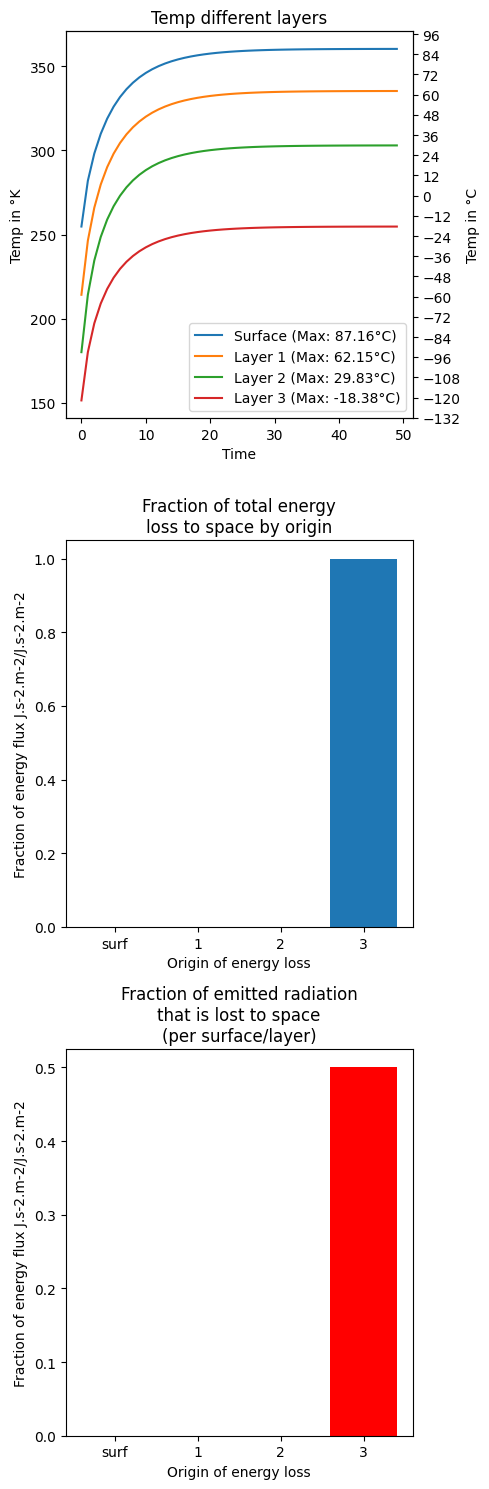

In [152]:
number_layers = 4
absorbtion = [1]
run_and_plot()

The surface temperature get's a bit high though. So let's add the transparency again: let's make sure that the surface still loses 10% of it's radiation to space.


Total energy sent back to space (sum_space_tot) 239.0 W.m-2.s-2


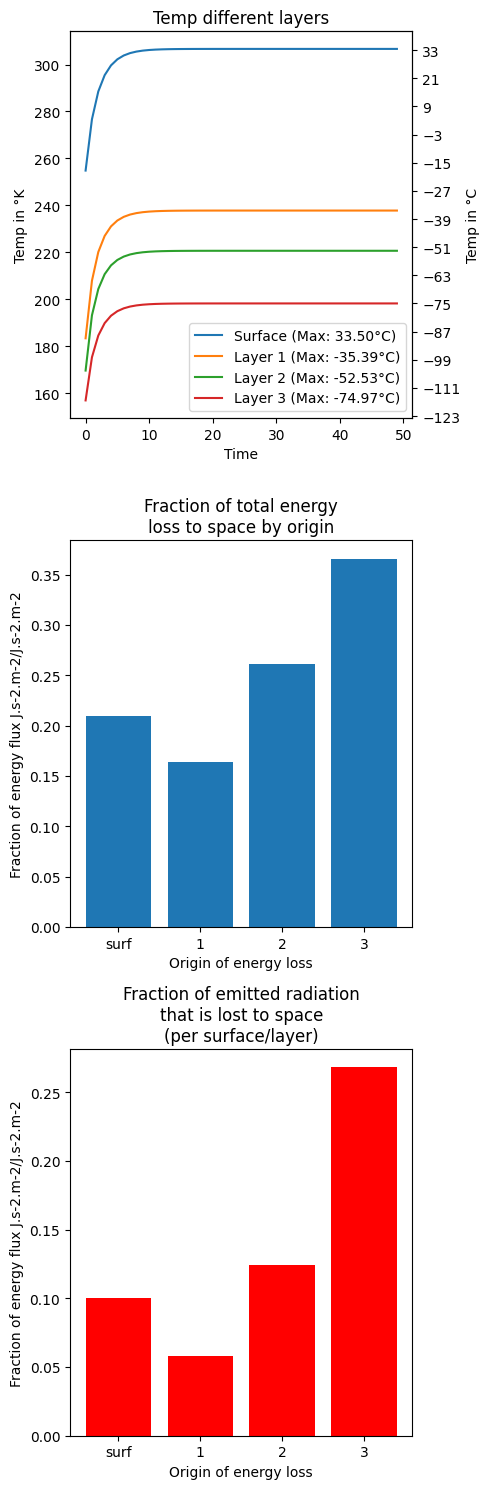

In [153]:
number_layers = 4
# This calculation ensures that 10% of the energy emitted by the surface is directly lost to space.
# To calculate how much is lost to space I multiply outgoing_up with the values for (1-absorbtion) of
# all higher layers. So (1-absorbtion)**(number_layers-1) has to be 0.1. So:
absorbtion = [1-(0.1**(1/(number_layers-1)))]
run_and_plot()

Plot 3 shows that the surface indeed still loses 10% of the radiation it emits to space.

Adding this transparency lowers the surface temperature to a more livable 33 °C.

The temperature of the top layer ("Layer 3") dips to a freezing -75°C. And even the the bottom layer (the one right above the surface, "Layer 1") doesn't get warmer than -35°C. 

We are seeing the same dynamic as we saw before: as warmer, lower layers (including the surface) can contribute to the energy loss to space, all layers (including the surface) can have a lower temperature, and still collectively emit 239 J.m<sup>-2</sup>.s<sup>-2</sup> to space.

As plot 2 and 3 show, the energy loss to space is simply more evenly distributed across the surface/layers. 

## Layer bonanza

Let's add some more layers and see what happens.

Total energy sent back to space (sum_space_tot) 239.0 W.m-2.s-2


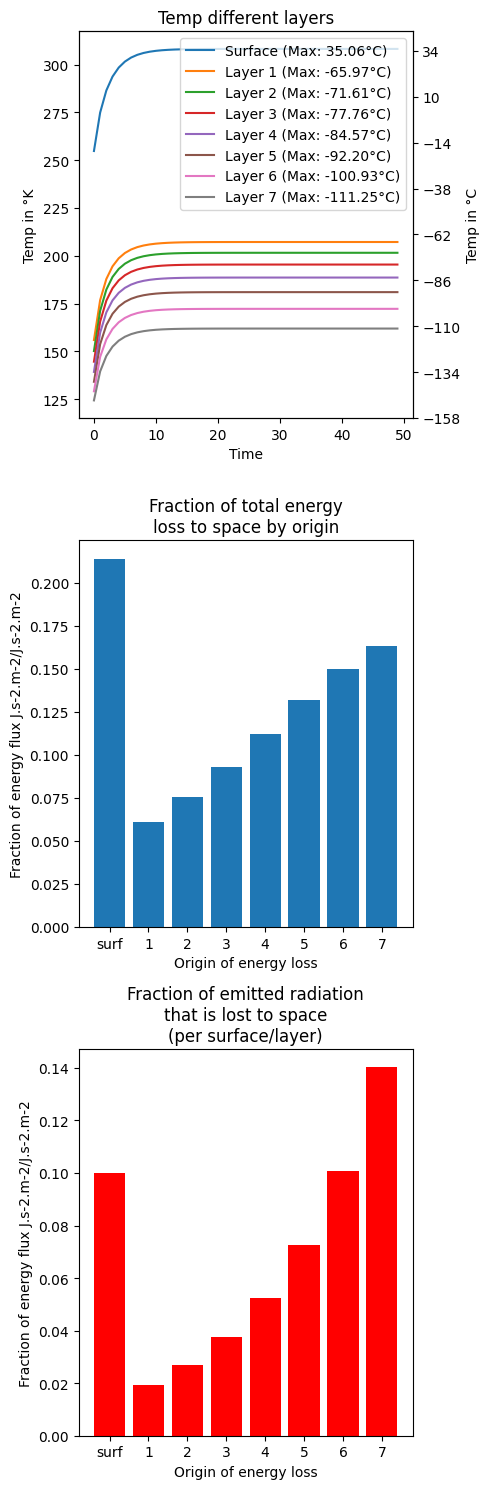

In [154]:
number_layers = 8
absorbtion = [1-(0.1**(1/(number_layers-1)))]
run_and_plot()

When adding more layers, several things stand out:

1. The surface temperature remains more or less the same (34°C). So does the fraction of total energy lost to space emanating from the surface (± 20%)
2. The fraction of the total energy lost to space emanating from individual *atmospheric layers*, however, goes down. And so does the temperature of all atmospheric layers.
4. As a result, the difference between the surface temperature and the temperature bottom layer (layer 1) increases.

Adding more layers simply reinforces the pattern observed before.

<a id="more_layers"></a>

Total energy sent back to space (sum_space_tot) 239.0 W.m-2.s-2


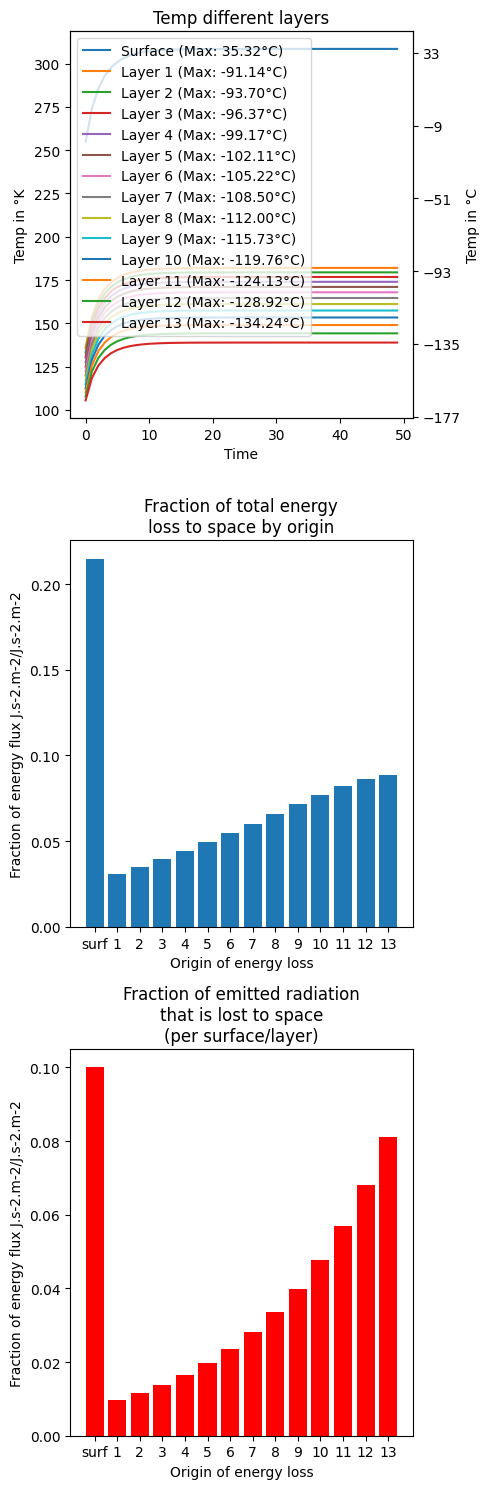

In [155]:
time = range(50)
number_layers = 14
absorbtion = [1-(0.1**(1/(number_layers-1)))]
run_and_plot()

What can explain this behaviour?

On a basic level, I think it makes sense that if the same flux of 239 J.m<sup>-2</sup>.s<sup>-2</sup> (that is lost to space) originates from more layers, each layer will have a smaller flux, and hence a lower temperature.

Also, whereas increasing the `number_layers` now decreases the `absorbtion` of the atmospheric layers (after all, I determine the `absorbtion` like this `absorbtion = [1-(0.1**(1/(number_layers-1)))]`), it does not lower the absorbtion rate of the surface (which remains 100%). This can explain the increase of the difference (in temperature) between the atmospheric layers and the surface.

Indeed, as the plots below show, using an absorbtion rate of 1 again, which effectively makes the atmospheric layers more like the surface (both absorb 100%), the big difference between the surface layer and the atmospheric layers disappears. 

Total energy sent back to space (sum_space_tot) 238.49 W.m-2.s-2


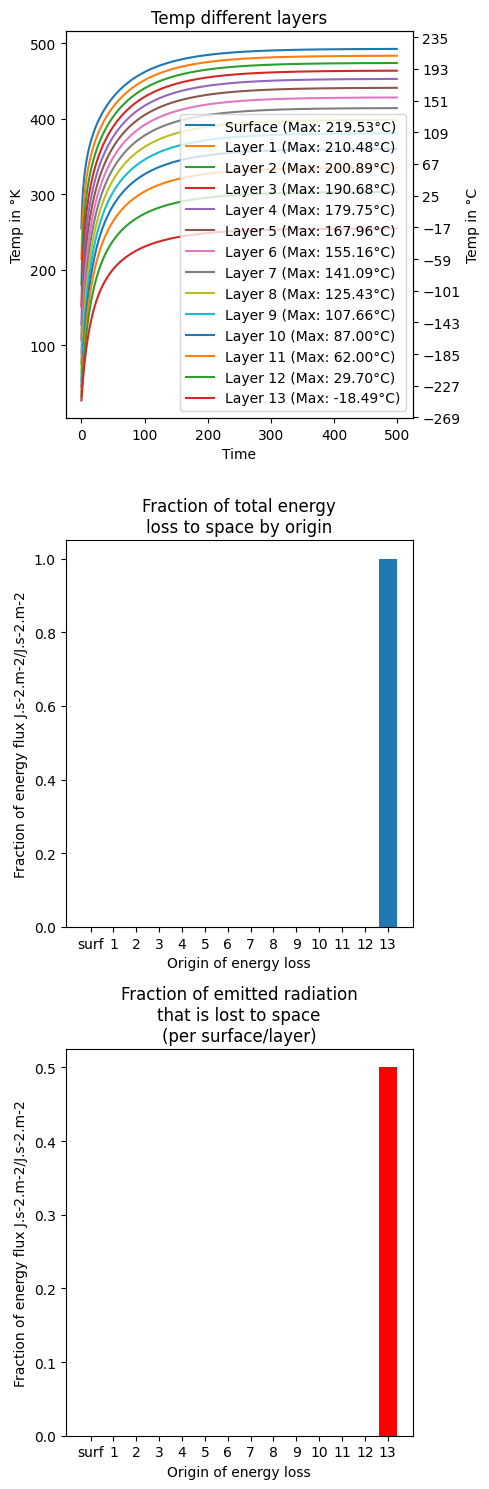

In [156]:
time = range(500)
number_layers = 14
absorbtion = [1]
run_and_plot()

## Underestimating temperature

Something seems to be a bit off: the higher the resolution of the model (the thinner the slices of the atmosphere), the lower the absorbtion rate per layer. That seems reasonable to me. But that means that the atmosphere gets colder? That's weird.

Part of the answer, I think, lies in the fact that the total energy flux (up or down) at any point in a vertical column of the atmosphere, is not only the radiation emitted by the layer at that altitude, but also the radiation emitted by layers above and below that layer: radiation that the layer in question is not absorbing and re-emitting itself. 

Given the Stefan-Boltzmann law (F = σ.T^4), (which describes the relationship between the flux of electromagnetic radiation and temperature in K°), I think it is fair to assume that by looking only at the energy that is radiated by a specific layer, and disregarding the fluxes from adjacent layers (that are passing through), we are underestimating the temperature at that point of the vertical column of atmosphere.

Indeed, as can be seen in the plots below, if I plot the temperature on the basis of all radiation emitted by AND *passing through* a layer, the temperature of the layers does not dramatically drop as I add more layers.

Total energy sent back to space (sum_space_tot) 239.0 W.m-2.s-2


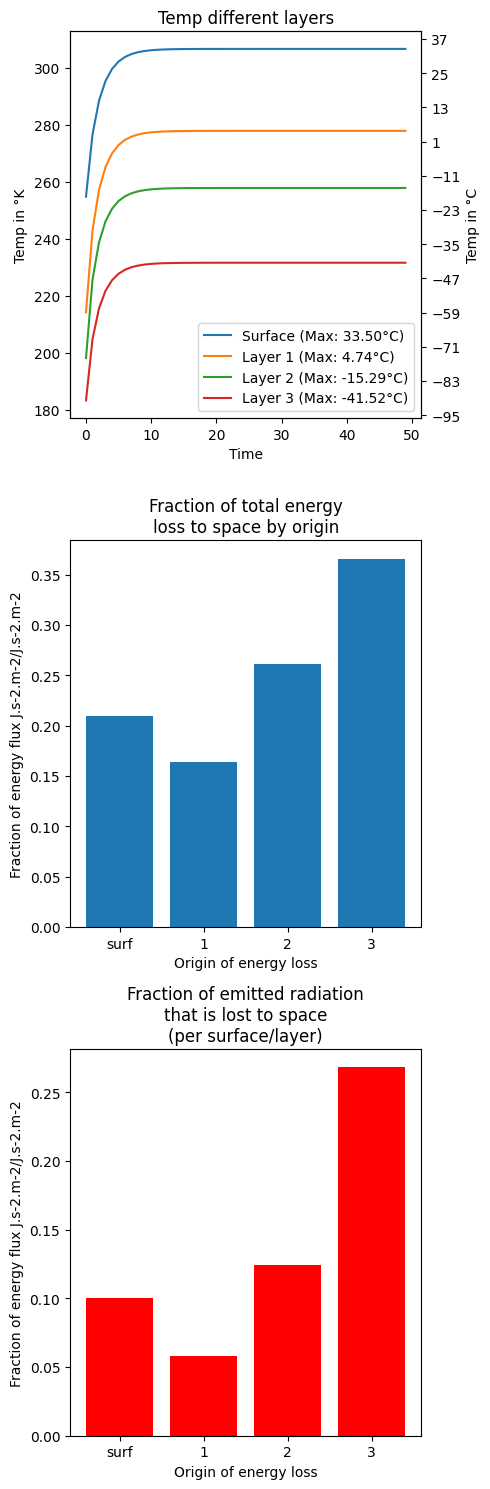

In [157]:
# Compare this example with 4 layers ...
time = range(50)
number_layers = 4
absorbtion = [1-(0.1**(1/(number_layers-1)))]
run_and_plot(temp_plot="atmosphere")

Total energy sent back to space (sum_space_tot) 239.0 W.m-2.s-2


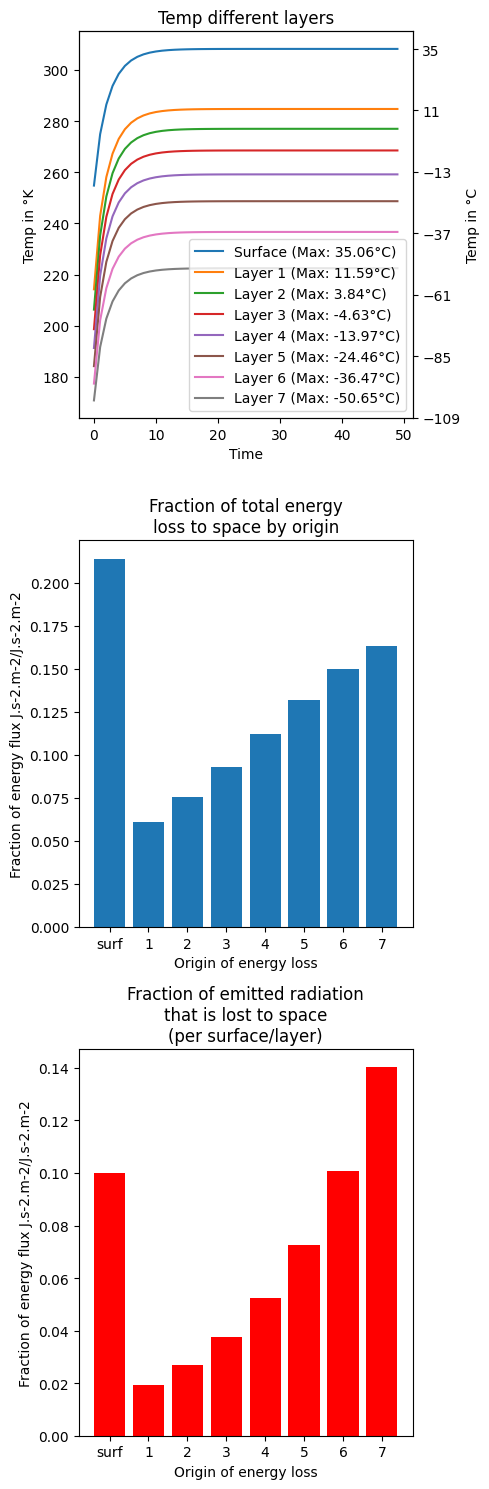

In [158]:
# ... with this example with 8 layers
time = range(50)
number_layers = 8
absorbtion = [1-(0.1**(1/(number_layers-1)))]
run_and_plot(temp_plot="atmosphere")

Total energy sent back to space (sum_space_tot) 239.0 W.m-2.s-2


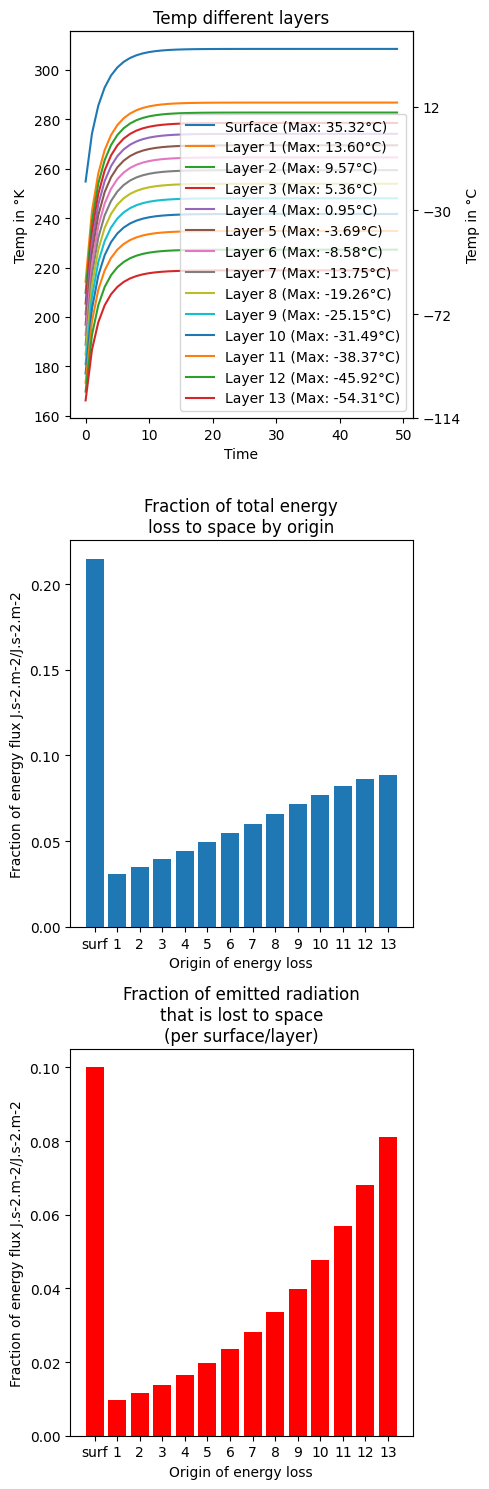

In [159]:
# ... and with this example with 14 layers
time = range(50)
number_layers = 14
absorbtion = [1-(0.1**(1/(number_layers-1)))]
run_and_plot(temp_plot="atmosphere")

## Decreasing absorbtion with altitude

Ok, let's add one final bit of complexity.

In reality the absorbtion rate of the atmosphere declines with altitude (as a result of the declining air pressure, and thus declining volumetric concentration of greenhouse gases).

Let's see what happens. And let's stick to the assumption that the surface loses about (40/390)th of its radiation directly to space.

Total transparency: 0.101


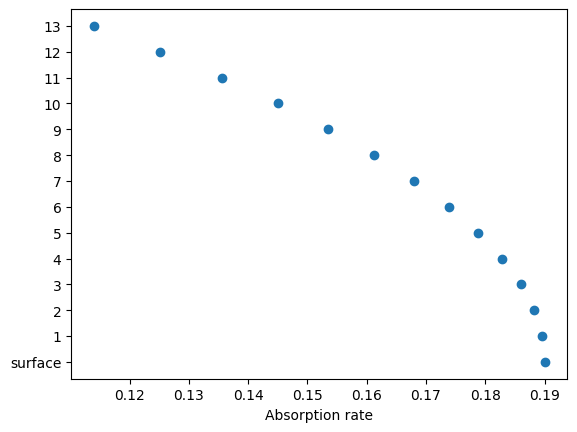

Total energy sent back to space (sum_space_tot) 239.0 W.m-2.s-2


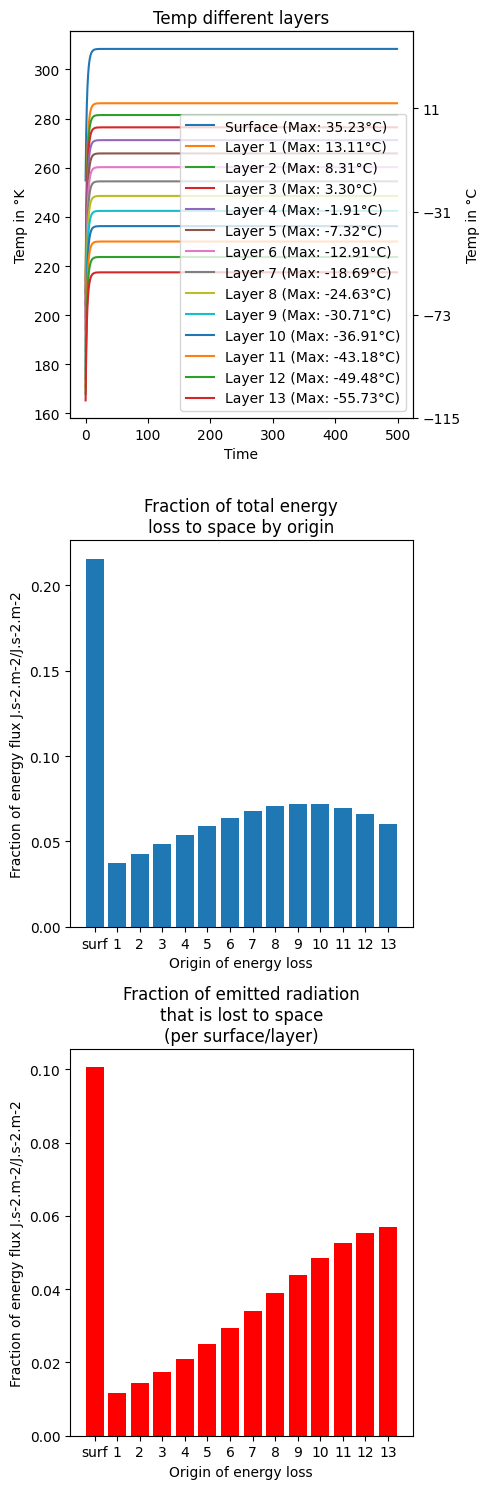

In [160]:
number_layers = 14

# The relation between the position of the layer and the absorbtion rate
absorbtion = [0.19-(0.00045 * x**2) for x in range(number_layers)]

# Check if the total transaperency of all layers is still 10%
# (If the surface can still lose 10% of its energy to space).
transparency = 1
for x in absorbtion[1:]:
    transparency = transparency * (1-x)
print(f"Total transparency: {round(transparency,3)}")

# Plot the relation between layer and absorbtion rate
plt.scatter(absorbtion,range(number_layers))
plt.gca().set_yticks(range(number_layers))
plt.gca().set_yticklabels(['surface']+[str(i) for i in np.arange(1, number_layers)])
plt.xlabel("Absorption rate")
plt.show()

time = range(500)
run_and_plot(temp_plot="atmosphere")

The results are not that different from [this](#more_layers) model run. The only effect it seems to have is that the atmospheric layer that contributes most to the energy loss to space is no longer the top layer. Which I think makes sense.

# Speculations about discrepancy model-reality

As I mentioned in the [introduction](#introduction), I have no pretentions when it comes to the accuracy or realism of the model. Still, just like [Kump et al.](https://mishathings.org/public/Kump-p53.pdf) speculated about the effects of adding complexity to their model, I can speculate about the effects of adding complexity to mine.

To be clear, the simulated average surface temperature on Earth is still way too high. Even in the last version of the model (with multiple layers, altitude dependent absorbtion, and the corrected temperature) the surface temperature is still 35°C, as opposed to the actual average surface temperature of 15°C.

But as the image of the energy balance (shown again below) already shows, electromagnetic radiation is not the only form of vertical energy transfer: there is also convection (warm air rising), there is the transport of latent heat (water evaporates below, and condenses higher up), and even conduction can play a role.

![energy balance](balance.jpeg "Energy balance")

Again, I am not an atmospheric scientists so I don't know whether adding these features to the model would help close the gap between simulation and reality. After all, maybe the model is wrong. 

But at least it is comforting that some key processes that I have left out, would probably help redistribute the heat between the surface and the atmosphere, and would thus probably help bring down the modelled surface temperature to more realistic levels.